In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
import matplotlib.pyplot as plt
import huggingface_stats
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/erik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_csv('0-10000-labeled.csv')
dataset_docs = dataset['article'].tolist()
dataset_y = dataset['label'].astype('int').tolist()

Een preprocessor wordt gebruikt om de data te preprocessen. Dit is een class met meerdere methods, bijvoorbeeld om alle woorden in een document te tellen.

In [3]:
preprocessor = huggingface_stats.Preprocessor(stemmer=EnglishStemmer(),
                                              stopwords=stopwords.words('english'),
                                              re_pattern=re.compile("[a-zA-Z]"))

Je kunt eventueel van tevoren de documenten filteren op keywords:

In [4]:
# pas deze if-statement aan om keyword filteren aan of uit te zetten
filter_by_keywords = True
if filter_by_keywords:
    positive_keywords = ['accident','disaster','catastrophe','incident','near-miss', 'tragedy', 'victim',
                         'casualties','died','killed','damage','harm','hospital','hospitalized',
                         'wounded','succumbed','unscathed','evacuate','rescue','first responders','ambulance',
                         'first aid', 'sunk','fire','derailed','collision','poisoned','burned', 'safety']
    negative_keywords = ['gunman', 'suspect', 'attack', 'terror', 'war', 'bombing', 'militants', 'bombs',
                         'conflict', 'hijacking']
    preprocessor.init_keyword_filter(positive=positive_keywords,
                                     pos_threshold=3,
                                     negative=negative_keywords,
                                     neg_threshold=3)
    pass_filter = preprocessor.batch_keyword_filter(docs=dataset_docs, show_progress=True)
    dataset_docs = np.array(dataset_docs)[np.array(pass_filter)].tolist()
    dataset_y = np.array(dataset_y)[np.array(pass_filter)].tolist()
    

100%|██████████| 10000/10000 [01:26<00:00, 115.36it/s]


In [5]:
len(dataset_y)

1802

In [6]:
print('dataset contains', np.sum(np.array(dataset_y) == 0), 'documents labeled 0')
print('dataset contains', np.sum(np.array(dataset_y) == 1), 'documents labeled 1')

dataset contains 1344 documents labeled 0
dataset contains 458 documents labeled 1


De gelabelde dataset wordt opgesplitst in train en test set:

In [7]:
docs_train, docs_test, y_train, y_test = train_test_split(dataset_docs, dataset_y, test_size=.25)

Een 'scorer' berekent een score voor elk document:

In [8]:
scorer = huggingface_stats.tf_idf_document_scorer(preprocessor=preprocessor,
                                                  docs=docs_train,
                                                  labels=y_train,
                                                  show_progress=True)

100%|██████████| 1009/1009 [00:11<00:00, 89.09it/s]


Dit zijn de woorden die het meest en minst wegen voor class 'wel ongeluk':

In [9]:
pd.DataFrame(list(scorer._weights.items())).sort_values(1, ascending=False)

,0,1
1545,plane,2.256783
1045,crash,2.199972
1380,flood,1.401755
4211,pilot,1.381858
2709,flight,1.162863
...,...,...
836,drug,-0.788443
66,murder,-0.804249
510,shoot,-0.836628
101,attack,-0.916190


In [10]:
X_train = scorer.batch_score(docs_train, show_progress=True)

100%|██████████| 1351/1351 [00:13<00:00, 102.20it/s]


Score voor positief gelabelde documenten:

In [11]:
np.array(X_train)[np.array(y_train) == 1][:50]

array([ -4.95295916,  50.37393798,  13.61586317,  27.97960352,
        61.61760246,  30.6245437 , -15.61441544,  65.81354546,
        32.54323447,  48.46766519,   6.7456247 ,  24.6790891 ,
        28.70691977,  27.85794713,  26.25609728,   1.91296834,
         4.1167333 ,  27.03272623, -45.08114203,  41.01124709,
        16.98804977, 104.61872095, -26.11333232,  11.83769301,
        24.89074643,  73.813281  , -37.43404345,  26.43557247,
         9.11281033, 122.62334102,   9.5862031 ,  33.01777281,
        50.80969367,   6.39651132,  29.70958489,  13.05354881,
        -2.57733009,   3.62658899,  38.24219246,  -2.73011731,
       -15.05631744,   3.79073524,  15.2559806 , -10.48758043,
        -7.41911321,  -2.5819736 ,  -8.11658416,  45.05699   ,
        33.90673402,  84.44470269])

score voor negatief gelabelde documenten:

In [12]:
np.array(X_train)[np.array(y_train) == 0][:50]

array([-37.80290963, -67.21216192, -29.61884594, -74.41121323,
       -62.4593321 ,  -3.90668165, -11.97958076, -41.67505854,
       -38.62079139, -50.70182225, -13.31361664, -49.22525869,
       -31.59627795,  17.30239642, -64.35088111, -44.56713323,
       -23.53640395, -17.55478123, -47.37449497, -42.53248751,
       -23.99013482, -65.56477169, -47.90064145, -82.0977034 ,
         9.45100228, -28.12677897, -37.41596671, -64.68066591,
       -53.61865951, -92.25347111, -46.35393291, -77.1870992 ,
        -2.33871562, -81.06210324, -30.80302341,  -6.78745331,
       -61.46795093, -41.62265319, -17.79401903, -77.93027442,
       -30.07040335, -40.05334527, -20.21159412, -53.94566038,
       -45.8633276 ,  -6.74926764, -34.55764785,  58.77102001,
       -16.3915447 , -23.76715247])

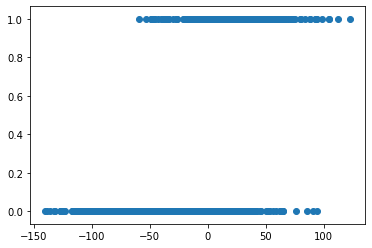

In [13]:
plt.scatter(X_train, y_train)

Met die score kan vervolgens logistieke regressie gedaan worden:

In [14]:
model = LogisticRegression(random_state=0).fit(np.array([X_train]).T, y_train)

In [15]:
X_test = scorer.batch_score(docs_test, show_progress=True)

100%|██████████| 451/451 [00:04<00:00, 102.15it/s]


In [16]:
y_predict = model.predict(np.array([X_test]).T)

In [17]:
print(classification_report(y_test, y_predict, target_names=['not accident', 'accident']))

              precision    recall  f1-score   support

not accident       0.87      0.94      0.90       335
    accident       0.76      0.58      0.66       116

    accuracy                           0.84       451
   macro avg       0.81      0.76      0.78       451
weighted avg       0.84      0.84      0.84       451

